# Import and setup

In [1]:
import os
import random
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

# Librerie personalizzate
from dataset import BloodCellDataset
from model import CustomModel
from train import train_one_epoch, validate
from utils import plot_confusion_matrix, plot_normalized_confusion_matrix

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

c:\Users\Mauro\anaconda3\envs\my_ai_env\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 # Parameters

In [25]:
DATASET_PATH = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\DATASETS\LEUCEMIA\Final"
VALID_FOLDERS = []
IMG_SIZE = 400

TEST_RATIO = 0.1  # 10% test esterno
N_FOLDS = 5
SEED = 42

BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
MODEL_NAME = "tf_efficientnetv2_b0"
PRETRAINED = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cuda


# Dataset Creation
Carichiamo il dataset e lo prepariamo istanziando la classe BloodCellDataset. Nel secondo blocco mostriamo la composizione del dataset

In [5]:
full_dataset = BloodCellDataset(
    root_dir=DATASET_PATH,
    valid_folders=VALID_FOLDERS,
    img_size=IMG_SIZE,
    transform=None  # No transformations
)

all_labels = np.array(full_dataset.labels) # Return all labels in the dataset
all_indices = np.arange(len(full_dataset)) # Return the indices ot all the examples in the dataset

In [ ]:
import collections

def print_dataset_composition(dataset):
    # Conta le occorrenze delle label in full_dataset.labels
    class_counts = collections.Counter(dataset.labels)
    total = len(dataset)
    print(f"Totale immagini: {total}")
    print("Composizione per classe:")
    for class_idx, count in class_counts.items():
        class_name = dataset.classes[class_idx]
        percentage = (count / total) * 100
        print(f"  Classe '{class_name}' (label {class_idx}): {count} immagini ({percentage:.2f}%)")

# Supponendo che full_dataset sia istanza di BloodCellDataset
print_dataset_composition(full_dataset)

# Separazione 10% come final test set
Fa uno shuffle degli indici di tutti gli esempi, per classe, e li separa in test set e train set. Il test set è il 10% del totale di esempi (presi in modo randomico)

In [7]:
class_to_indices = {} 
# Group the indices of the examples by class and put them in a dictionary class_to_indices
for idx, label in enumerate(all_labels):
    class_to_indices.setdefault(label, []).append(idx)

test_indices = [] # List of indices for the test set
trainval_indices = [] # List of indices for the train+val set (for K-fold cross-validation)

for label, idx_list in class_to_indices.items():
    idx_arr = np.array(idx_list) # Convert the list of indices to a numpy array
    np.random.shuffle(idx_arr)  # Shuffle the indices
    n_test = int(len(idx_arr)*TEST_RATIO) # Number of test examples for the current class

    test_part = idx_arr[:n_test] # Take n_test random indices for the test set
    train_part = idx_arr[n_test:]  # Take the remaining indices for the train set

    test_indices.extend(test_part) # Add the test indices to the test set
    trainval_indices.extend(train_part) # Add the train indices to the train set

test_indices = np.array(test_indices)
trainval_indices = np.array(trainval_indices)

print(f"Test set esterno: {len(test_indices)} esempi")
print(f"Train+Val set (K-fold): {len(trainval_indices)} esempi")

final_test_dataset = Subset(full_dataset, test_indices) # Test set 

Test set esterno: 3298 esempi
Train+Val set (K-fold): 29720 esempi


# K-FOLD
Il dataset composto dal 90% degli esempi (stratificato per classe) viene impiegato per il K-Fold cross validation.

In [9]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
labels_for_90 = all_labels[trainval_indices]

# Data augmentation per train
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=180, p=0.5),
    A.RandomBrightnessContrast(p=0.1),
    A.Resize(IMG_SIZE,IMG_SIZE),
    ToTensorV2()
])

# Transform di base per val/test
val_transform = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    ToTensorV2()
])

# Per la WeightedRandomSampler, calcoliamo le class weights
# 1 / freq_di_classe = peso. (Es. meno frequente = peso maggiore)
unique_labels, counts = np.unique(labels_for_90, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

# Ad es. weight[class] = 1/count
max_count = max(class_counts.values())
weight_per_class = {}
for c, cnt in class_counts.items():
    weight_per_class[c] = max_count / cnt  # un modo per "bilanciare"

def make_sampler(indices_array):
    # Ritorna un WeightedRandomSampler per oversampling
    # in base a weight_per_class.
    sample_weights = []
    for idx in indices_array:
        label = all_labels[idx]
        sample_weights.append(weight_per_class[label])
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(indices_array),  # parità con dimensione set
        replacement=True  # sampling con rimpiazzo
    )
    return sampler

# Funzione per creare un dataset con transform
class SubsetAlbumentations(Dataset):
    def __init__(self, base_dataset, indices, albumentations_transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = albumentations_transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        real_idx = self.indices[i]
        img, label = self.base_dataset[real_idx]
        # Se dataset ritorna un np array HxWxC o un Tensor CxHxW...
        # Adattiamo per Albumentations
        if isinstance(img, torch.Tensor):
            img_np = img.permute(1,2,0).numpy()
        else:
            img_np = img
        if self.transform:
            augmented = self.transform(image=img_np)
            img = augmented["image"]
        return img, label

fold_accuracies = []
fold_number = 1

# K FOLD EXEC

In [7]:
for train_idx, val_idx in skf.split(trainval_indices, labels_for_90):
    print(f"\n=== Fold {fold_number}/{N_FOLDS} ===")
    real_train_indices = trainval_indices[train_idx]
    real_val_indices   = trainval_indices[val_idx]

    print("Train set fold:", len(real_train_indices), "| Val set fold:", len(real_val_indices))

    ds_train = SubsetAlbumentations(full_dataset, real_train_indices, albumentations_transform=train_transform)
    ds_val   = SubsetAlbumentations(full_dataset, real_val_indices, albumentations_transform=val_transform)

    sampler_train = make_sampler(real_train_indices)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler_train, num_workers=0)
    dl_val   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = CustomModel(
        num_classes=full_dataset.num_classes,
        model_name=MODEL_NAME,
        pretrained=PRETRAINED
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        print(f"  Epoch {epoch+1}/{EPOCHS}")
        train_loss, train_acc = train_one_epoch(model, dl_train, criterion, optimizer, DEVICE)
        val_loss, val_acc, precision, recall, f1, preds, labels = validate(model, dl_val, criterion, DEVICE)

        print(f"    TrainLoss: {train_loss:.4f}  Acc: {train_acc:.4f}"
              f" | ValLoss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        # --- SALVATAGGIO DEL BEST MODEL ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{MODEL_NAME}_best_fold{fold_number}.pth")
            print(f"    ► Salvo best model per fold {fold_number} con val_acc = {best_val_acc:.4f}")

    fold_accuracies.append(best_val_acc)
    print(f"*** Best Val Acc Fold {fold_number}: {best_val_acc:.4f} ***")

    fold_number += 1



=== Fold 1/5 ===
Train set fold: 23776 | Val set fold: 5944
  Epoch 1/20


    TrainLoss: 0.8458  Acc: 0.7116 | ValLoss: 0.3636  Acc: 0.8627
    ► Salvo best model per fold 1 con val_acc = 0.8627
  Epoch 2/20


    TrainLoss: 0.4197  Acc: 0.8597 | ValLoss: 0.2718  Acc: 0.9006
    ► Salvo best model per fold 1 con val_acc = 0.9006
  Epoch 3/20


    TrainLoss: 0.3525  Acc: 0.8805 | ValLoss: 0.2413  Acc: 0.9177
    ► Salvo best model per fold 1 con val_acc = 0.9177
  Epoch 4/20


    TrainLoss: 0.2954  Acc: 0.9000 | ValLoss: 0.2594  Acc: 0.9105
  Epoch 5/20


    TrainLoss: 0.2585  Acc: 0.9140 | ValLoss: 0.2626  Acc: 0.9061
  Epoch 6/20


    TrainLoss: 0.2451  Acc: 0.9173 | ValLoss: 0.2743  Acc: 0.9105
  Epoch 7/20


    TrainLoss: 0.2273  Acc: 0.9225 | ValLoss: 0.2039  Acc: 0.9292
    ► Salvo best model per fold 1 con val_acc = 0.9292
  Epoch 8/20


    TrainLoss: 0.2156  Acc: 0.9258 | ValLoss: 0.2483  Acc: 0.9107
  Epoch 9/20


    TrainLoss: 0.2019  Acc: 0.9302 | ValLoss: 0.1724  Acc: 0.9404
    ► Salvo best model per fold 1 con val_acc = 0.9404
  Epoch 10/20


    TrainLoss: 0.1890  Acc: 0.9344 | ValLoss: 0.1945  Acc: 0.9335
  Epoch 11/20


    TrainLoss: 0.1896  Acc: 0.9359 | ValLoss: 0.2136  Acc: 0.9255
  Epoch 12/20


    TrainLoss: 0.1737  Acc: 0.9397 | ValLoss: 0.1698  Acc: 0.9425
    ► Salvo best model per fold 1 con val_acc = 0.9425
  Epoch 13/20


    TrainLoss: 0.1670  Acc: 0.9422 | ValLoss: 0.2024  Acc: 0.9283
  Epoch 14/20


    TrainLoss: 0.1590  Acc: 0.9465 | ValLoss: 0.1828  Acc: 0.9369
  Epoch 15/20


    TrainLoss: 0.1580  Acc: 0.9454 | ValLoss: 0.1568  Acc: 0.9477
    ► Salvo best model per fold 1 con val_acc = 0.9477
  Epoch 16/20


    TrainLoss: 0.1466  Acc: 0.9497 | ValLoss: 0.1864  Acc: 0.9342
  Epoch 17/20


    TrainLoss: 0.1444  Acc: 0.9503 | ValLoss: 0.1868  Acc: 0.9389
  Epoch 18/20


    TrainLoss: 0.1358  Acc: 0.9531 | ValLoss: 0.2120  Acc: 0.9285
  Epoch 19/20


    TrainLoss: 0.1350  Acc: 0.9542 | ValLoss: 0.1788  Acc: 0.9389
  Epoch 20/20


    TrainLoss: 0.1318  Acc: 0.9549 | ValLoss: 0.1741  Acc: 0.9421
*** Best Val Acc Fold 1: 0.9477 ***

=== Fold 2/5 ===
Train set fold: 23776 | Val set fold: 5944
  Epoch 1/20


    TrainLoss: 0.8564  Acc: 0.7055 | ValLoss: 0.3477  Acc: 0.8767
    ► Salvo best model per fold 2 con val_acc = 0.8767
  Epoch 2/20


    TrainLoss: 0.3983  Acc: 0.8679 | ValLoss: 0.3213  Acc: 0.8864
    ► Salvo best model per fold 2 con val_acc = 0.8864
  Epoch 3/20


    TrainLoss: 0.3218  Acc: 0.8938 | ValLoss: 0.2855  Acc: 0.8955
    ► Salvo best model per fold 2 con val_acc = 0.8955
  Epoch 4/20


    TrainLoss: 0.2875  Acc: 0.9047 | ValLoss: 0.3113  Acc: 0.8974
    ► Salvo best model per fold 2 con val_acc = 0.8974
  Epoch 5/20


    TrainLoss: 0.2632  Acc: 0.9101 | ValLoss: 0.2661  Acc: 0.9056
    ► Salvo best model per fold 2 con val_acc = 0.9056
  Epoch 6/20


    TrainLoss: 0.2449  Acc: 0.9193 | ValLoss: 0.2444  Acc: 0.9122
    ► Salvo best model per fold 2 con val_acc = 0.9122
  Epoch 7/20


    TrainLoss: 0.2242  Acc: 0.9238 | ValLoss: 0.2317  Acc: 0.9184
    ► Salvo best model per fold 2 con val_acc = 0.9184
  Epoch 8/20


    TrainLoss: 0.2142  Acc: 0.9284 | ValLoss: 0.2238  Acc: 0.9214
    ► Salvo best model per fold 2 con val_acc = 0.9214
  Epoch 9/20


    TrainLoss: 0.1918  Acc: 0.9360 | ValLoss: 0.2430  Acc: 0.9184
  Epoch 10/20


    TrainLoss: 0.1795  Acc: 0.9380 | ValLoss: 0.1921  Acc: 0.9324
    ► Salvo best model per fold 2 con val_acc = 0.9324
  Epoch 11/20


    TrainLoss: 0.1827  Acc: 0.9397 | ValLoss: 0.2369  Acc: 0.9203
  Epoch 12/20


    TrainLoss: 0.1688  Acc: 0.9430 | ValLoss: 0.2097  Acc: 0.9278
  Epoch 13/20


    TrainLoss: 0.1499  Acc: 0.9486 | ValLoss: 0.2190  Acc: 0.9261
  Epoch 14/20


    TrainLoss: 0.1550  Acc: 0.9464 | ValLoss: 0.1800  Acc: 0.9379
    ► Salvo best model per fold 2 con val_acc = 0.9379
  Epoch 15/20


    TrainLoss: 0.1470  Acc: 0.9518 | ValLoss: 0.1838  Acc: 0.9341
  Epoch 16/20


    TrainLoss: 0.1488  Acc: 0.9489 | ValLoss: 0.1564  Acc: 0.9484
    ► Salvo best model per fold 2 con val_acc = 0.9484
  Epoch 17/20


    TrainLoss: 0.1442  Acc: 0.9514 | ValLoss: 0.1632  Acc: 0.9411
  Epoch 18/20


    TrainLoss: 0.1336  Acc: 0.9542 | ValLoss: 0.1713  Acc: 0.9369
  Epoch 19/20


    TrainLoss: 0.1302  Acc: 0.9572 | ValLoss: 0.2008  Acc: 0.9290
  Epoch 20/20


    TrainLoss: 0.1337  Acc: 0.9542 | ValLoss: 0.1569  Acc: 0.9500
    ► Salvo best model per fold 2 con val_acc = 0.9500
*** Best Val Acc Fold 2: 0.9500 ***

=== Fold 3/5 ===
Train set fold: 23776 | Val set fold: 5944
  Epoch 1/20


    TrainLoss: 0.8405  Acc: 0.7112 | ValLoss: 0.3951  Acc: 0.8583
    ► Salvo best model per fold 3 con val_acc = 0.8583
  Epoch 2/20


    TrainLoss: 0.4120  Acc: 0.8625 | ValLoss: 0.3709  Acc: 0.8676
    ► Salvo best model per fold 3 con val_acc = 0.8676
  Epoch 3/20


    TrainLoss: 0.3397  Acc: 0.8851 | ValLoss: 0.2906  Acc: 0.8965
    ► Salvo best model per fold 3 con val_acc = 0.8965
  Epoch 4/20


    TrainLoss: 0.3084  Acc: 0.8955 | ValLoss: 0.3322  Acc: 0.8932
  Epoch 5/20


    TrainLoss: 0.2710  Acc: 0.9092 | ValLoss: 0.2649  Acc: 0.9115
    ► Salvo best model per fold 3 con val_acc = 0.9115
  Epoch 6/20


    TrainLoss: 0.2464  Acc: 0.9167 | ValLoss: 0.2550  Acc: 0.9135
    ► Salvo best model per fold 3 con val_acc = 0.9135
  Epoch 7/20


    TrainLoss: 0.2261  Acc: 0.9235 | ValLoss: 0.2650  Acc: 0.9081
  Epoch 8/20


    TrainLoss: 0.2236  Acc: 0.9244 | ValLoss: 0.2174  Acc: 0.9253
    ► Salvo best model per fold 3 con val_acc = 0.9253
  Epoch 9/20


    TrainLoss: 0.1995  Acc: 0.9313 | ValLoss: 0.3624  Acc: 0.8880
  Epoch 10/20


    TrainLoss: 0.1939  Acc: 0.9339 | ValLoss: 0.2181  Acc: 0.9248
  Epoch 11/20


    TrainLoss: 0.1830  Acc: 0.9359 | ValLoss: 0.2528  Acc: 0.9189
  Epoch 12/20


    TrainLoss: 0.1664  Acc: 0.9418 | ValLoss: 0.2375  Acc: 0.9189
  Epoch 13/20


    TrainLoss: 0.1627  Acc: 0.9448 | ValLoss: 0.2297  Acc: 0.9266
    ► Salvo best model per fold 3 con val_acc = 0.9266
  Epoch 14/20


    TrainLoss: 0.1621  Acc: 0.9441 | ValLoss: 0.2138  Acc: 0.9314
    ► Salvo best model per fold 3 con val_acc = 0.9314
  Epoch 15/20


    TrainLoss: 0.1501  Acc: 0.9468 | ValLoss: 0.1742  Acc: 0.9458
    ► Salvo best model per fold 3 con val_acc = 0.9458
  Epoch 16/20


    TrainLoss: 0.1565  Acc: 0.9453 | ValLoss: 0.1796  Acc: 0.9426
  Epoch 17/20


    TrainLoss: 0.1411  Acc: 0.9507 | ValLoss: 0.2624  Acc: 0.9164
  Epoch 18/20


    TrainLoss: 0.1385  Acc: 0.9506 | ValLoss: 0.2104  Acc: 0.9376
  Epoch 19/20


    TrainLoss: 0.1366  Acc: 0.9536 | ValLoss: 0.1703  Acc: 0.9455
  Epoch 20/20


    TrainLoss: 0.1240  Acc: 0.9558 | ValLoss: 0.1811  Acc: 0.9418
*** Best Val Acc Fold 3: 0.9458 ***

=== Fold 4/5 ===
Train set fold: 23776 | Val set fold: 5944
  Epoch 1/20


    TrainLoss: 0.8622  Acc: 0.6996 | ValLoss: 0.4343  Acc: 0.8296
    ► Salvo best model per fold 4 con val_acc = 0.8296
  Epoch 2/20


    TrainLoss: 0.3963  Acc: 0.8690 | ValLoss: 0.3365  Acc: 0.8827
    ► Salvo best model per fold 4 con val_acc = 0.8827
  Epoch 3/20


    TrainLoss: 0.3324  Acc: 0.8892 | ValLoss: 0.2290  Acc: 0.9187
    ► Salvo best model per fold 4 con val_acc = 0.9187
  Epoch 4/20


    TrainLoss: 0.2916  Acc: 0.9033 | ValLoss: 0.2929  Acc: 0.8910
  Epoch 5/20


    TrainLoss: 0.2627  Acc: 0.9081 | ValLoss: 0.2513  Acc: 0.9085
  Epoch 6/20


    TrainLoss: 0.2403  Acc: 0.9177 | ValLoss: 0.2723  Acc: 0.9046
  Epoch 7/20


    TrainLoss: 0.2170  Acc: 0.9278 | ValLoss: 0.2091  Acc: 0.9297
    ► Salvo best model per fold 4 con val_acc = 0.9297
  Epoch 8/20


    TrainLoss: 0.2132  Acc: 0.9278 | ValLoss: 0.1785  Acc: 0.9415
    ► Salvo best model per fold 4 con val_acc = 0.9415
  Epoch 9/20


    TrainLoss: 0.1907  Acc: 0.9373 | ValLoss: 0.2191  Acc: 0.9272
  Epoch 10/20


    TrainLoss: 0.1928  Acc: 0.9354 | ValLoss: 0.1872  Acc: 0.9359
  Epoch 11/20


    TrainLoss: 0.1795  Acc: 0.9391 | ValLoss: 0.1742  Acc: 0.9393
  Epoch 12/20


    TrainLoss: 0.1768  Acc: 0.9380 | ValLoss: 0.2402  Acc: 0.9132
  Epoch 13/20


    TrainLoss: 0.1566  Acc: 0.9461 | ValLoss: 0.1674  Acc: 0.9403
  Epoch 14/20


    TrainLoss: 0.1585  Acc: 0.9456 | ValLoss: 0.2033  Acc: 0.9346
  Epoch 15/20


    TrainLoss: 0.1483  Acc: 0.9494 | ValLoss: 0.1932  Acc: 0.9275
  Epoch 16/20


    TrainLoss: 0.1440  Acc: 0.9496 | ValLoss: 0.1967  Acc: 0.9334
  Epoch 17/20


    TrainLoss: 0.1346  Acc: 0.9535 | ValLoss: 0.1591  Acc: 0.9455
    ► Salvo best model per fold 4 con val_acc = 0.9455
  Epoch 18/20


    TrainLoss: 0.1366  Acc: 0.9539 | ValLoss: 0.1836  Acc: 0.9367
  Epoch 19/20


    TrainLoss: 0.1309  Acc: 0.9563 | ValLoss: 0.1959  Acc: 0.9344
  Epoch 20/20


    TrainLoss: 0.1287  Acc: 0.9548 | ValLoss: 0.1986  Acc: 0.9297
*** Best Val Acc Fold 4: 0.9455 ***

=== Fold 5/5 ===
Train set fold: 23776 | Val set fold: 5944
  Epoch 1/20


    TrainLoss: 0.8479  Acc: 0.7086 | ValLoss: 0.4069  Acc: 0.8577
    ► Salvo best model per fold 5 con val_acc = 0.8577
  Epoch 2/20


    TrainLoss: 0.4231  Acc: 0.8595 | ValLoss: 0.3020  Acc: 0.8785
    ► Salvo best model per fold 5 con val_acc = 0.8785
  Epoch 3/20


    TrainLoss: 0.3388  Acc: 0.8865 | ValLoss: 0.2575  Acc: 0.9051
    ► Salvo best model per fold 5 con val_acc = 0.9051
  Epoch 4/20


    TrainLoss: 0.3007  Acc: 0.8970 | ValLoss: 0.2521  Acc: 0.9014
  Epoch 5/20


    TrainLoss: 0.2680  Acc: 0.9105 | ValLoss: 0.2558  Acc: 0.9046
  Epoch 6/20


    TrainLoss: 0.2481  Acc: 0.9159 | ValLoss: 0.2497  Acc: 0.9076
    ► Salvo best model per fold 5 con val_acc = 0.9076
  Epoch 7/20


    TrainLoss: 0.2368  Acc: 0.9211 | ValLoss: 0.2955  Acc: 0.8975
  Epoch 8/20


    TrainLoss: 0.2148  Acc: 0.9270 | ValLoss: 0.2317  Acc: 0.9181
    ► Salvo best model per fold 5 con val_acc = 0.9181
  Epoch 9/20


    TrainLoss: 0.1966  Acc: 0.9325 | ValLoss: 0.2260  Acc: 0.9218
    ► Salvo best model per fold 5 con val_acc = 0.9218
  Epoch 10/20


    TrainLoss: 0.1920  Acc: 0.9336 | ValLoss: 0.2565  Acc: 0.9150
  Epoch 11/20


    TrainLoss: 0.1790  Acc: 0.9382 | ValLoss: 0.2776  Acc: 0.9086
  Epoch 12/20


    TrainLoss: 0.1737  Acc: 0.9386 | ValLoss: 0.2537  Acc: 0.9097
  Epoch 13/20


    TrainLoss: 0.1641  Acc: 0.9442 | ValLoss: 0.1929  Acc: 0.9319
    ► Salvo best model per fold 5 con val_acc = 0.9319
  Epoch 14/20


    TrainLoss: 0.1577  Acc: 0.9456 | ValLoss: 0.2118  Acc: 0.9236
  Epoch 15/20


    TrainLoss: 0.1576  Acc: 0.9453 | ValLoss: 0.1969  Acc: 0.9273
  Epoch 16/20


    TrainLoss: 0.1489  Acc: 0.9487 | ValLoss: 0.1821  Acc: 0.9383
    ► Salvo best model per fold 5 con val_acc = 0.9383
  Epoch 17/20


    TrainLoss: 0.1441  Acc: 0.9508 | ValLoss: 0.1918  Acc: 0.9305
  Epoch 18/20


    TrainLoss: 0.1411  Acc: 0.9530 | ValLoss: 0.1996  Acc: 0.9305
  Epoch 19/20


    TrainLoss: 0.1309  Acc: 0.9546 | ValLoss: 0.1878  Acc: 0.9330
  Epoch 20/20


    TrainLoss: 0.1291  Acc: 0.9560 | ValLoss: 0.1855  Acc: 0.9330
*** Best Val Acc Fold 5: 0.9383 ***


# Risultati k-cross

In [ ]:
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"\nRISULTATI CROSS VALIDATION: acc media {mean_acc:.4f} +/- {std_acc:.4f}")



RISULTATI CROSS VALIDATION: acc media nan +/- nan


# Training su tutto il 90% e test

In [10]:
ds_train_90 = SubsetAlbumentations(full_dataset, trainval_indices, albumentations_transform=train_transform)
sampler_90  = make_sampler(trainval_indices)
dl_train_90 = DataLoader(ds_train_90, batch_size=BATCH_SIZE, sampler=sampler_90, num_workers=0)

ds_test = SubsetAlbumentations(full_dataset, test_indices, albumentations_transform=val_transform)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

final_model = CustomModel(num_classes=full_dataset.num_classes, model_name=MODEL_NAME, pretrained=PRETRAINED).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=LR)

In [10]:
from sklearn.model_selection import train_test_split

# ... Tutto il codice precedente (k-fold, ecc.) rimane invariato ...

# ===============================
# 1) SPLIT FINALE 85-15 NEL 90%
# ===============================
train_indices_85, val_indices_15 = train_test_split(
    trainval_indices, 
    test_size=0.15, 
    random_state=SEED, 
    stratify=labels_for_90  # per stratificare in base alle classi
)

print(f"\n*** Suddivisione finale su 90% ***")
print(f"Train set: {len(train_indices_85)} esempi | Validation set: {len(val_indices_15)} esempi")

# ===============================
# 2) DATASET E DATALOADER PER IL 85%/15%
# ===============================
ds_train_85 = SubsetAlbumentations(
    full_dataset, 
    train_indices_85, 
    albumentations_transform=train_transform
)
ds_val_15   = SubsetAlbumentations(
    full_dataset, 
    val_indices_15, 
    albumentations_transform=val_transform
)

sampler_85 = make_sampler(train_indices_85)  # WeightedRandomSampler solo sul train
dl_train_85 = DataLoader(ds_train_85, batch_size=BATCH_SIZE, sampler=sampler_85, num_workers=0)
dl_val_15   = DataLoader(ds_val_15, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# (Test set è già definito come ds_test / dl_test da prima)
# dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# 3) MODELLO, LOSS, OPTIMIZER
# ===============================
final_model = CustomModel(
    num_classes=full_dataset.num_classes, 
    model_name=MODEL_NAME, 
    pretrained=PRETRAINED
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=LR)

# ===============================
# 4) TRAINING FINALE PER 30 EPOCHE 
#    (monitora valid set 15%)
# ===============================
EPOCHS = 30
best_val_acc = 0.0

print("\n=== TRAINING FINALE (85% train, 15% val) ===")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # --- Training su 85% ---
    train_loss, train_acc = train_one_epoch(final_model, dl_train_85, criterion, optimizer, DEVICE)

    # --- Validation su 15% ---
    val_loss, val_acc, precision, recall, f1, preds, labels = validate(final_model, dl_val_15, criterion, DEVICE)

    print(f"    [Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"    [Val]   Loss: {val_loss:.4f}   | Acc: {val_acc:.4f}")

    # Salvataggio del best model in base a val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(final_model.state_dict(), f"{MODEL_NAME}_best_85_15.pth")
        print(f"    -> Salvo BEST model (val_acc={best_val_acc:.4f})")

# ===============================
# 5) EVALUATION SUL TEST (10% FINALE)
# ===============================
print("\n=== EVAL SUL TEST SET (10%) ===")
# Ricarica (opzionale) il best model
final_model.load_state_dict(torch.load(f"{MODEL_NAME}_best_85_15.pth"))

test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = validate(final_model, dl_test, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1: {test_f1:.4f}")

torch.save(final_model.state_dict(), f"{MODEL_NAME}_final_85_15.pth")
print("► Salvato modello finale addestrato con split 85-15 su 90%.")



*** Suddivisione finale su 90% ***
Train set: 25262 esempi | Validation set: 4458 esempi

=== TRAINING FINALE (85% train, 15% val) ===
Epoch 1/30


KeyboardInterrupt: 

In [10]:
print("\n=== TRAINING FINALE SU TUTTO IL 90% ===")
EPOCHS = 30
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(final_model, dl_train_90, criterion, optimizer, DEVICE)
    print(f"  [FinalTrain] E{epoch+1}/{EPOCHS}  Loss {train_loss:.4f} Acc {train_acc:.4f}")

torch.save(final_model.state_dict(), f"{MODEL_NAME}_final_90perc.pth")
print("► Salvato il modello addestrato su tutto il 90%.")


=== TRAINING FINALE SU TUTTO IL 90% ===


KeyboardInterrupt: 

In [11]:
print("\n=== TRAINING FINALE SU TUTTO IL 90% ===")
EPOCHS = 30
best_val_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(final_model, dl_train_90, criterion, optimizer, DEVICE)
    val_loss, val_acc, precision, recall, f1, preds, labels = validate(final_model, dl_test, criterion, DEVICE)

    print(f"    TrainLoss: {train_loss:.4f}  Acc: {train_acc:.4f}"
              f" | ValLoss: {val_loss:.4f}  Acc: {val_acc:.4f}")

    # --- SALVATAGGIO DEL BEST MODEL ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(final_model.state_dict(), f"{MODEL_NAME}_best_90.pth")
        print(f"    ► Salvo best model per fold {fold_number} con val_acc = {best_val_acc:.4f}")

torch.save(final_model.state_dict(), f"{MODEL_NAME}_final_90perc.pth")
print("► Salvato il modello addestrato su tutto il 90%.")


=== TRAINING FINALE SU TUTTO IL 90% ===


    TrainLoss: 0.7156  Acc: 0.7539 | ValLoss: 0.3413  Acc: 0.8742
    ► Salvo best model per fold 6 con val_acc = 0.8742


    TrainLoss: 0.3770  Acc: 0.8729 | ValLoss: 0.2956  Acc: 0.8936
    ► Salvo best model per fold 6 con val_acc = 0.8936


    TrainLoss: 0.3074  Acc: 0.8970 | ValLoss: 0.2645  Acc: 0.9027
    ► Salvo best model per fold 6 con val_acc = 0.9027


    TrainLoss: 0.2731  Acc: 0.9080 | ValLoss: 0.2484  Acc: 0.9118
    ► Salvo best model per fold 6 con val_acc = 0.9118


    TrainLoss: 0.2487  Acc: 0.9158 | ValLoss: 0.2203  Acc: 0.9269
    ► Salvo best model per fold 6 con val_acc = 0.9269


    TrainLoss: 0.2252  Acc: 0.9198 | ValLoss: 0.2655  Acc: 0.9145


    TrainLoss: 0.2110  Acc: 0.9288 | ValLoss: 0.1978  Acc: 0.9294
    ► Salvo best model per fold 6 con val_acc = 0.9294


    TrainLoss: 0.1989  Acc: 0.9322 | ValLoss: 0.2216  Acc: 0.9218


    TrainLoss: 0.1842  Acc: 0.9379 | ValLoss: 0.2406  Acc: 0.9221


    TrainLoss: 0.1803  Acc: 0.9396 | ValLoss: 0.1867  Acc: 0.9384
    ► Salvo best model per fold 6 con val_acc = 0.9384


    TrainLoss: 0.1762  Acc: 0.9410 | ValLoss: 0.2173  Acc: 0.9300


    TrainLoss: 0.1569  Acc: 0.9469 | ValLoss: 0.1869  Acc: 0.9403
    ► Salvo best model per fold 6 con val_acc = 0.9403


    TrainLoss: 0.1526  Acc: 0.9470 | ValLoss: 0.2147  Acc: 0.9333


    TrainLoss: 0.1515  Acc: 0.9488 | ValLoss: 0.1783  Acc: 0.9460
    ► Salvo best model per fold 6 con val_acc = 0.9460


    TrainLoss: 0.1433  Acc: 0.9513 | ValLoss: 0.1743  Acc: 0.9451


    TrainLoss: 0.1463  Acc: 0.9484 | ValLoss: 0.2752  Acc: 0.9048


    TrainLoss: 0.1352  Acc: 0.9537 | ValLoss: 0.1685  Acc: 0.9460


    TrainLoss: 0.1345  Acc: 0.9547 | ValLoss: 0.2862  Acc: 0.9069


    TrainLoss: 0.1242  Acc: 0.9565 | ValLoss: 0.2101  Acc: 0.9351


    TrainLoss: 0.1158  Acc: 0.9592 | ValLoss: 0.1975  Acc: 0.9327


    TrainLoss: 0.1171  Acc: 0.9594 | ValLoss: 0.1526  Acc: 0.9478
    ► Salvo best model per fold 6 con val_acc = 0.9478


    TrainLoss: 0.1184  Acc: 0.9587 | ValLoss: 0.1624  Acc: 0.9488
    ► Salvo best model per fold 6 con val_acc = 0.9488


    TrainLoss: 0.1161  Acc: 0.9603 | ValLoss: 0.2007  Acc: 0.9321


    TrainLoss: 0.1093  Acc: 0.9620 | ValLoss: 0.1720  Acc: 0.9424


    TrainLoss: 0.1041  Acc: 0.9641 | ValLoss: 0.1811  Acc: 0.9451


    TrainLoss: 0.1078  Acc: 0.9632 | ValLoss: 0.1787  Acc: 0.9418


    TrainLoss: 0.1038  Acc: 0.9649 | ValLoss: 0.1561  Acc: 0.9506
    ► Salvo best model per fold 6 con val_acc = 0.9506


    TrainLoss: 0.1067  Acc: 0.9633 | ValLoss: 0.1684  Acc: 0.9445


    TrainLoss: 0.0955  Acc: 0.9679 | ValLoss: 0.1830  Acc: 0.9406


    TrainLoss: 0.0977  Acc: 0.9666 | ValLoss: 0.1447  Acc: 0.9572
    ► Salvo best model per fold 6 con val_acc = 0.9572
► Salvato il modello addestrato su tutto il 90%.


# Valutazione

In [13]:
test_loss, test_acc, p, r, f1, preds, labels = validate(final_model, dl_test, criterion, DEVICE)
print("\n=== TEST FINALE (10%) ===")
print(f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
print(f"Precision {p:.2f}, Recall {r:.2f}, F1 {f1:.2f}")

plot_confusion_matrix(labels, preds, full_dataset.classes)
plot_normalized_confusion_matrix(labels, preds, full_dataset.classes)

KeyboardInterrupt: 

=== EVALUATION DEL MODELLO CARICATO ===
Test Loss 0.1447, Test Acc 0.9572
Precision 0.96, Recall 0.96, F1 0.96


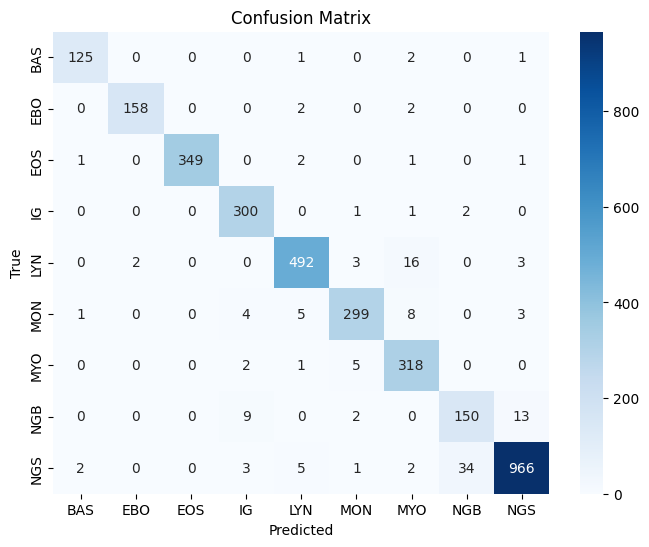

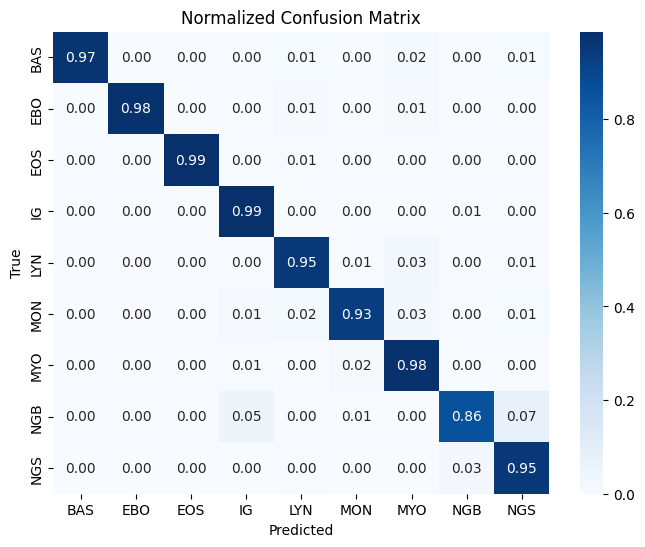

In [31]:
# 1) Crea un’istanza del modello, identico a quello usato in training
loaded_model = CustomModel(
    num_classes=full_dataset.num_classes,
    model_name="tf_efficientnetv2_b0", 
    pretrained=False
).to(DEVICE)

# 2) Carica i pesi salvati
loaded_model.load_state_dict(torch.load("tf_efficientnetv2_b0_best_90.pth"))

# 3) Metti il modello in eval mode
loaded_model.eval()

# 4) Valuta sul test set
test_loss, test_acc, p, r, f1, preds, labels = validate(
    loaded_model, 
    dl_test,      # il DataLoader del test
    criterion,    # ad esempio nn.CrossEntropyLoss()
    DEVICE
)

print("=== EVALUATION DEL MODELLO CARICATO ===")
print(f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
print(f"Precision {p:.2f}, Recall {r:.2f}, F1 {f1:.2f}")

plot_confusion_matrix(labels, preds, full_dataset.classes)
plot_normalized_confusion_matrix(labels, preds, full_dataset.classes)


In [ ]:

model_effnet = CustomModel(num_classes=9, model_name="tf_efficientnetv2_b0", pretrained=False)

print("\n=== EfficientNet-B0 layers ===")
print(model_effnet)

from torchinfo import summary
summary(model_effnet, input_size=(1, 3, 400, 400))



=== EfficientNet-B0 layers ===
CustomModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats

Layer (type:depth-idx)                             Output Shape              Param #
CustomModel                                        [1, 9]                    --
├─EfficientNet: 1-1                                [1, 9]                    --
│    └─Conv2dSame: 2-1                             [1, 32, 200, 200]         864
│    └─BatchNormAct2d: 2-2                         [1, 32, 200, 200]         64
│    │    └─Identity: 3-1                          [1, 32, 200, 200]         --
│    │    └─SiLU: 3-2                              [1, 32, 200, 200]         --
│    └─Sequential: 2-3                             [1, 192, 13, 13]          --
│    │    └─Sequential: 3-3                        [1, 16, 200, 200]         4,640
│    │    └─Sequential: 3-4                        [1, 32, 100, 100]         52,736
│    │    └─Sequential: 3-5                        [1, 48, 50, 50]           136,000
│    │    └─Sequential: 3-6                        [1, 96, 25, 25]           230,652
│    │    └─Seque

In [42]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)
print(model.blocks)


Total parameters: 5870233
Sequential(
  (0): Sequential(
    (0): ConvBnAct(
      (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (aa): Identity()
      (drop_path): Identity()
    )
  )
  (1): Sequential(
    (0): EdgeResidual(
      (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (aa): Identity()
      (se): Identity()
      (conv_pwl): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Identity()
      )
     

In [12]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

# Load the necessary functions & dataset class
def load_model(model_path, num_classes, device):
    model = CustomModel(num_classes=num_classes, model_name=MODEL_NAME, pretrained=False)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Function to calculate Sensitivity and Specificity
def compute_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []

    for i in range(num_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

    return sensitivity, specificity

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate through each fold
results = []
fold_number = 1

for train_idx, val_idx in skf.split(trainval_indices, labels_for_90):
    print(f"\nEvaluating Fold {fold_number}...")

    # Load validation dataset
    real_val_indices = trainval_indices[val_idx]
    ds_val = SubsetAlbumentations(full_dataset, real_val_indices, albumentations_transform=val_transform)
    dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Load trained model for this fold
    model_path = f"{MODEL_NAME}_best_fold{fold_number}.pth"
    model = load_model(model_path, num_classes=full_dataset.num_classes, device=DEVICE)

    all_preds = []
    all_labels = []

    # Run inference on validation set
    with torch.no_grad():
        for images, labels in dl_val:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(full_dataset.num_classes))

    # Compute sensitivity and specificity
    sensitivity, specificity = compute_metrics(cm)

    # Store results in DataFrame
    df_fold = pd.DataFrame({
        "Class": list(range(full_dataset.num_classes)),
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Fold": [fold_number] * full_dataset.num_classes
    })

    results.append(df_fold)
    fold_number += 1




Evaluating Fold 1...

Evaluating Fold 2...

Evaluating Fold 3...

Evaluating Fold 4...

Evaluating Fold 5...


In [ ]:
# Concatenate all results
df_results = pd.concat(results, ignore_index=True)
%pip install ace_tools
# Display the final results
import ace_tools as tools
tools.display_dataframe_to_user(name="Sensitivity & Specificity per Fold", dataframe=df_results)

# Optionally, save to CSV
df_results.to_csv("sensitivity_specificity_per_fold.csv", index=False)

print("\n✅ Sensitivity & Specificity computed for all folds.")

ModuleNotFoundError: No module named 'ace_tools'

# Analisi qualitativa

Classe prevista: 0   Fiducia: 0.9982786178588867


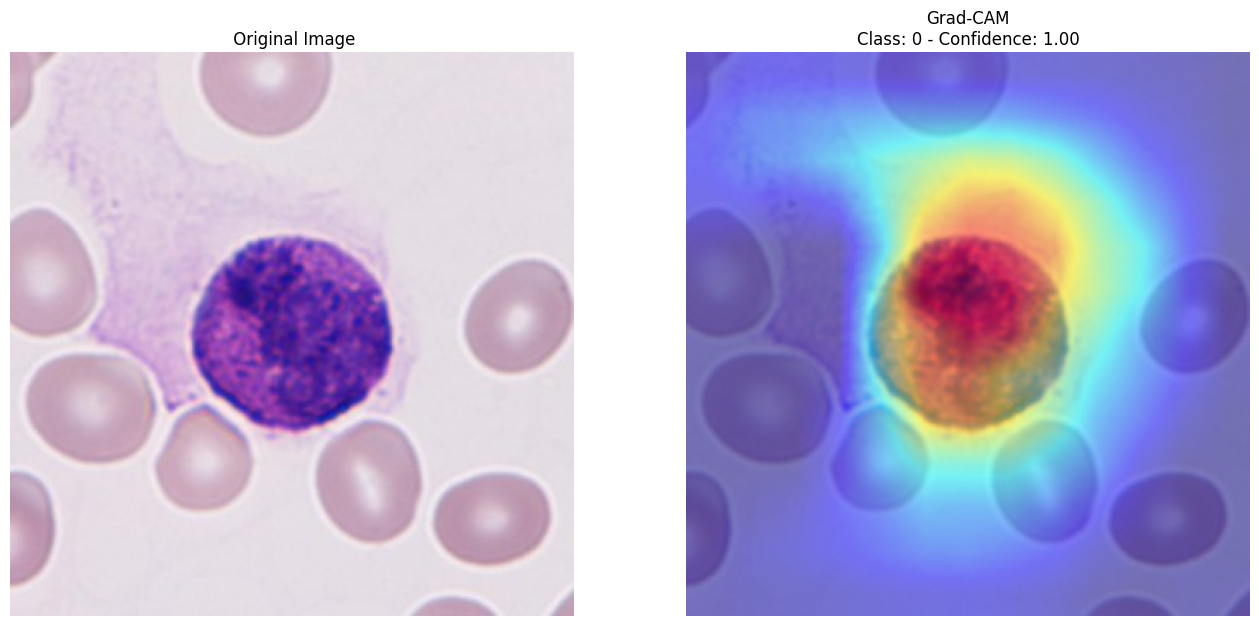

In [46]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Configura il dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crea il modello EfficientNet-B0 senza pesi predefiniti
model_effnet = timm.create_model(MODEL_NAME, pretrained=False)

# Resetta il classifier per avere 4 classi
model_effnet.reset_classifier(num_classes=9)

# Carica lo state_dict e rimuovi il prefisso "model." se presente
model_weights_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\Progetto\MindBigData\finale_resnet\tf_efficientnetv2_b0_best_90.pth"
state_dict = torch.load(model_weights_path, map_location=device)
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key[len("model."):] if key.startswith("model.") else key
    new_state_dict[new_key] = value

model_effnet.load_state_dict(new_state_dict)
model_effnet = model_effnet.to(device)
model_effnet.eval()

# Scegli il layer target (l'ultimo blocco convoluzionale)
target_layer_effnet = model_effnet.blocks[-1]

# Carica l'immagine di test
img_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\DATASETS\LEUCEMIA\Final\BAS\BA_529390.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Carica in BGR
if img is None:
    raise ValueError(f"Impossibile caricare l'immagine da {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ridimensiona e normalizza l'immagine
img_resized = cv2.resize(img, (400, 400))
img_normalized = img_resized.astype(np.float32) / 255.0

# Prepara il tensore in formato (1, 3, 400, 400)
input_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).to(device)

# Esegui la classificazione
with torch.no_grad():
    outputs = model_effnet(input_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence, predicted_class = torch.max(probabilities, dim=1)

predicted_class = predicted_class.item()
confidence = confidence.item()
print("Classe prevista:", predicted_class, "  Fiducia:", confidence)

# Calcola Grad-CAM
cam_effnet = GradCAM(model=model_effnet, target_layers=[target_layer_effnet])
grayscale_cam = cam_effnet(input_tensor=input_tensor)[0]
cam_image = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)

# Visualizza l'immagine originale, la Grad-CAM e la classificazione
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title(" Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title(f"Grad-CAM\nClass: {predicted_class} - Confidence: {confidence:.2f}")
plt.axis("off")

plt.show()

In [ ]:
# --- CALCOLO DELLE METRICHE DEL MODELLO FINALE ---
model = CustomModel(num_classes=9, model_name="tf_efficientnetv2_b0", pretrained=PRETRAINED)
model.to(DEVICE)  # Assicura che il modello sia sul dispositivo corretto (CPU o GPU)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def memory_footprint(model):
    return sum(p.numel() * p.element_size() for p in model.parameters())

print("\n=== Misurazioni del modello finale ===")
print("Numero di parametri:", count_parameters(model))
print("Memory footprint (bytes):", memory_footprint(model))

# Calcolo dei FLOPs usando ptflops
from ptflops import get_model_complexity_info
dummy_input_size = (3, IMG_SIZE, IMG_SIZE)
flops, params_str = get_model_complexity_info(model, dummy_input_size,
                                             as_strings=True,
                                             print_per_layer_stat=False)
print("FLOPs:", flops)
print("Params (da ptflops):", params_str)

def measure_inference_time(model, dataset, device, n_images=1000, batch_size=32):
    from torch.utils.data import DataLoader
    import time

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    total_images = 0
    total_time = 0.0
    model.eval()

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start = time.time()

            _ = model(images)

            if device.type == 'cuda':
                torch.cuda.synchronize()
            end = time.time()

            total_time += (end - start)
            total_images += images.size(0)
            if total_images >= n_images:
                break

    avg_time = total_time / min(total_images, n_images)
    return avg_time, total_time

# Esegui il calcolo del tempo di inferenza
n_inference = min(1000, len(final_test_dataset))
avg_time, total_time = measure_inference_time(model, final_test_dataset, DEVICE,
                                              n_images=n_inference,
                                              batch_size=BATCH_SIZE)
print(f"Tempo di inferenza medio per immagine: {avg_time:.6f} secondi")
print(f"Tempo totale per inferenza su {n_inference} immagini: {total_time:.6f} secondi")


=== Misurazioni del modello finale ===
Numero di parametri: 5870233
Memory footprint (bytes): 23480932
FLOPs: 2.12 GMac
Params (da ptflops): 5.87 M
Tempo di inferenza medio per immagine: 0.001286 secondi
Tempo totale per inferenza su 1000 immagini: 1.286052 secondi


# Misura tempo inferenza

In [23]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timm
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Configura il dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crea il modello EfficientNet-B0 senza pesi predefiniti
model_effnet = timm.create_model('efficientnet_b0', pretrained=False)

# Resetta il classifier per avere 4 classi
model_effnet.reset_classifier(num_classes=4)

# Carica lo state_dict e rimuovi il prefisso "model." se presente
model_weights_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\Progetto\MindBigData\finale_resnet\tf_efficientnetv2_b0_best_90.pth"
state_dict = torch.load(model_weights_path, map_location=device)
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key[len("model."):] if key.startswith("model.") else key
    new_state_dict[new_key] = value

model_effnet.load_state_dict(new_state_dict)
model_effnet = model_effnet.to(device)
model_effnet.eval()

# Scegli il layer target (l'ultimo blocco convoluzionale)
target_layer_effnet = model_effnet.blocks[-1]

# Carica l'immagine di test
img_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\DATASETS\LEUCEMIA\PKG-AML-Cytomorphology_LMU\LYT\LYT_1104.tiff"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Carica l'immagine in BGR
if img is None:
    raise ValueError(f"Impossibile caricare l'immagine da {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ridimensiona e normalizza l'immagine
img_resized = cv2.resize(img, (400, 400))
img_normalized = img_resized.astype(np.float32) / 255.0

# Prepara il tensore in formato (1, 3, 400, 400)
input_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).to(device)

# Misura il tempo di inferenza
start_time = time.time()
with torch.no_grad():
    outputs = model_effnet(input_tensor)
end_time = time.time()
inference_time = end_time - start_time

# Calcola le probabilità, la classe e la fiducia
probabilities = torch.nn.functional.softmax(outputs, dim=1)
confidence, predicted_class = torch.max(probabilities, dim=1)
predicted_class = predicted_class.item()
confidence = confidence.item()

print("Classe prevista:", predicted_class, "  Fiducia:", confidence)
print("Tempo di inferenza: {:.4f} secondi".format(inference_time))

# Calcola Grad-CAM
cam_effnet = GradCAM(model=model_effnet, target_layers=[target_layer_effnet])
grayscale_cam = cam_effnet(input_tensor=input_tensor)[0]
cam_image = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)

# Visualizza l'immagine originale, la Grad-CAM e la classificazione
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Immagine originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title(f"Grad-CAM\nClasse: {predicted_class} - Fiducia: {confidence:.2f}")
plt.axis("off")

plt.show()

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "blocks.0.0.conv_dw.weight", "blocks.0.0.se.conv_reduce.weight", "blocks.0.0.se.conv_reduce.bias", "blocks.0.0.se.conv_expand.weight", "blocks.0.0.se.conv_expand.bias", "blocks.0.0.conv_pw.weight", "blocks.0.0.bn2.weight", "blocks.0.0.bn2.bias", "blocks.0.0.bn2.running_mean", "blocks.0.0.bn2.running_var", "blocks.1.0.conv_pw.weight", "blocks.1.0.conv_dw.weight", "blocks.1.0.se.conv_reduce.weight", "blocks.1.0.se.conv_reduce.bias", "blocks.1.0.se.conv_expand.weight", "blocks.1.0.se.conv_expand.bias", "blocks.1.0.bn3.weight", "blocks.1.0.bn3.bias", "blocks.1.0.bn3.running_mean", "blocks.1.0.bn3.running_var", "blocks.1.1.conv_pw.weight", "blocks.1.1.conv_dw.weight", "blocks.1.1.se.conv_reduce.weight", "blocks.1.1.se.conv_reduce.bias", "blocks.1.1.se.conv_expand.weight", "blocks.1.1.se.conv_expand.bias", "blocks.1.1.bn3.weight", "blocks.1.1.bn3.bias", "blocks.1.1.bn3.running_mean", "blocks.1.1.bn3.running_var", "blocks.2.0.conv_pw.weight", "blocks.2.0.conv_dw.weight", "blocks.2.0.se.conv_reduce.weight", "blocks.2.0.se.conv_reduce.bias", "blocks.2.0.se.conv_expand.weight", "blocks.2.0.se.conv_expand.bias", "blocks.2.0.bn3.weight", "blocks.2.0.bn3.bias", "blocks.2.0.bn3.running_mean", "blocks.2.0.bn3.running_var", "blocks.2.1.conv_pw.weight", "blocks.2.1.conv_dw.weight", "blocks.2.1.se.conv_reduce.weight", "blocks.2.1.se.conv_reduce.bias", "blocks.2.1.se.conv_expand.weight", "blocks.2.1.se.conv_expand.bias", "blocks.2.1.bn3.weight", "blocks.2.1.bn3.bias", "blocks.2.1.bn3.running_mean", "blocks.2.1.bn3.running_var", "blocks.6.0.conv_pw.weight", "blocks.6.0.bn1.weight", "blocks.6.0.bn1.bias", "blocks.6.0.bn1.running_mean", "blocks.6.0.bn1.running_var", "blocks.6.0.conv_dw.weight", "blocks.6.0.bn2.weight", "blocks.6.0.bn2.bias", "blocks.6.0.bn2.running_mean", "blocks.6.0.bn2.running_var", "blocks.6.0.se.conv_reduce.weight", "blocks.6.0.se.conv_reduce.bias", "blocks.6.0.se.conv_expand.weight", "blocks.6.0.se.conv_expand.bias", "blocks.6.0.conv_pwl.weight", "blocks.6.0.bn3.weight", "blocks.6.0.bn3.bias", "blocks.6.0.bn3.running_mean", "blocks.6.0.bn3.running_var". 
	Unexpected key(s) in state_dict: "blocks.0.0.conv.weight", "blocks.1.0.conv_exp.weight", "blocks.1.1.conv_exp.weight", "blocks.2.0.conv_exp.weight", "blocks.2.1.conv_exp.weight", "blocks.4.3.conv_pw.weight", "blocks.4.3.bn1.weight", "blocks.4.3.bn1.bias", "blocks.4.3.bn1.running_mean", "blocks.4.3.bn1.running_var", "blocks.4.3.bn1.num_batches_tracked", "blocks.4.3.conv_dw.weight", "blocks.4.3.bn2.weight", "blocks.4.3.bn2.bias", "blocks.4.3.bn2.running_mean", "blocks.4.3.bn2.running_var", "blocks.4.3.bn2.num_batches_tracked", "blocks.4.3.se.conv_reduce.weight", "blocks.4.3.se.conv_reduce.bias", "blocks.4.3.se.conv_expand.weight", "blocks.4.3.se.conv_expand.bias", "blocks.4.3.conv_pwl.weight", "blocks.4.3.bn3.weight", "blocks.4.3.bn3.bias", "blocks.4.3.bn3.running_mean", "blocks.4.3.bn3.running_var", "blocks.4.3.bn3.num_batches_tracked", "blocks.4.4.conv_pw.weight", "blocks.4.4.bn1.weight", "blocks.4.4.bn1.bias", "blocks.4.4.bn1.running_mean", "blocks.4.4.bn1.running_var", "blocks.4.4.bn1.num_batches_tracked", "blocks.4.4.conv_dw.weight", "blocks.4.4.bn2.weight", "blocks.4.4.bn2.bias", "blocks.4.4.bn2.running_mean", "blocks.4.4.bn2.running_var", "blocks.4.4.bn2.num_batches_tracked", "blocks.4.4.se.conv_reduce.weight", "blocks.4.4.se.conv_reduce.bias", "blocks.4.4.se.conv_expand.weight", "blocks.4.4.se.conv_expand.bias", "blocks.4.4.conv_pwl.weight", "blocks.4.4.bn3.weight", "blocks.4.4.bn3.bias", "blocks.4.4.bn3.running_mean", "blocks.4.4.bn3.running_var", "blocks.4.4.bn3.num_batches_tracked", "blocks.5.4.conv_pw.weight", "blocks.5.4.bn1.weight", "blocks.5.4.bn1.bias", "blocks.5.4.bn1.running_mean", "blocks.5.4.bn1.running_var", "blocks.5.4.bn1.num_batches_tracked", "blocks.5.4.conv_dw.weight", "blocks.5.4.bn2.weight", "blocks.5.4.bn2.bias", "blocks.5.4.bn2.running_mean", "blocks.5.4.bn2.running_var", "blocks.5.4.bn2.num_batches_tracked", "blocks.5.4.se.conv_reduce.weight", "blocks.5.4.se.conv_reduce.bias", "blocks.5.4.se.conv_expand.weight", "blocks.5.4.se.conv_expand.bias", "blocks.5.4.conv_pwl.weight", "blocks.5.4.bn3.weight", "blocks.5.4.bn3.bias", "blocks.5.4.bn3.running_mean", "blocks.5.4.bn3.running_var", "blocks.5.4.bn3.num_batches_tracked", "blocks.5.5.conv_pw.weight", "blocks.5.5.bn1.weight", "blocks.5.5.bn1.bias", "blocks.5.5.bn1.running_mean", "blocks.5.5.bn1.running_var", "blocks.5.5.bn1.num_batches_tracked", "blocks.5.5.conv_dw.weight", "blocks.5.5.bn2.weight", "blocks.5.5.bn2.bias", "blocks.5.5.bn2.running_mean", "blocks.5.5.bn2.running_var", "blocks.5.5.bn2.num_batches_tracked", "blocks.5.5.se.conv_reduce.weight", "blocks.5.5.se.conv_reduce.bias", "blocks.5.5.se.conv_expand.weight", "blocks.5.5.se.conv_expand.bias", "blocks.5.5.conv_pwl.weight", "blocks.5.5.bn3.weight", "blocks.5.5.bn3.bias", "blocks.5.5.bn3.running_mean", "blocks.5.5.bn3.running_var", "blocks.5.5.bn3.num_batches_tracked", "blocks.5.6.conv_pw.weight", "blocks.5.6.bn1.weight", "blocks.5.6.bn1.bias", "blocks.5.6.bn1.running_mean", "blocks.5.6.bn1.running_var", "blocks.5.6.bn1.num_batches_tracked", "blocks.5.6.conv_dw.weight", "blocks.5.6.bn2.weight", "blocks.5.6.bn2.bias", "blocks.5.6.bn2.running_mean", "blocks.5.6.bn2.running_var", "blocks.5.6.bn2.num_batches_tracked", "blocks.5.6.se.conv_reduce.weight", "blocks.5.6.se.conv_reduce.bias", "blocks.5.6.se.conv_expand.weight", "blocks.5.6.se.conv_expand.bias", "blocks.5.6.conv_pwl.weight", "blocks.5.6.bn3.weight", "blocks.5.6.bn3.bias", "blocks.5.6.bn3.running_mean", "blocks.5.6.bn3.running_var", "blocks.5.6.bn3.num_batches_tracked", "blocks.5.7.conv_pw.weight", "blocks.5.7.bn1.weight", "blocks.5.7.bn1.bias", "blocks.5.7.bn1.running_mean", "blocks.5.7.bn1.running_var", "blocks.5.7.bn1.num_batches_tracked", "blocks.5.7.conv_dw.weight", "blocks.5.7.bn2.weight", "blocks.5.7.bn2.bias", "blocks.5.7.bn2.running_mean", "blocks.5.7.bn2.running_var", "blocks.5.7.bn2.num_batches_tracked", "blocks.5.7.se.conv_reduce.weight", "blocks.5.7.se.conv_reduce.bias", "blocks.5.7.se.conv_expand.weight", "blocks.5.7.se.conv_expand.bias", "blocks.5.7.conv_pwl.weight", "blocks.5.7.bn3.weight", "blocks.5.7.bn3.bias", "blocks.5.7.bn3.running_mean", "blocks.5.7.bn3.running_var", "blocks.5.7.bn3.num_batches_tracked". 
	size mismatch for blocks.0.0.bn1.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.bn1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.bn1.running_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.bn1.running_var: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.1.0.bn1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn2.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn2.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.conv_pwl.weight: copying a param with shape torch.Size([32, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 96, 1, 1]).
	size mismatch for blocks.1.1.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn2.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn2.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.conv_pwl.weight: copying a param with shape torch.Size([32, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 144, 1, 1]).
	size mismatch for blocks.2.0.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn2.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn2.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn2.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.conv_pwl.weight: copying a param with shape torch.Size([48, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 144, 1, 1]).
	size mismatch for blocks.2.1.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn2.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn2.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn2.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.conv_pwl.weight: copying a param with shape torch.Size([48, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for blocks.3.0.conv_pw.weight: copying a param with shape torch.Size([192, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for blocks.3.0.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.conv_dw.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for blocks.3.0.bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.se.conv_reduce.weight: copying a param with shape torch.Size([12, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for blocks.3.0.se.conv_reduce.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for blocks.3.0.se.conv_expand.weight: copying a param with shape torch.Size([192, 12, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for blocks.3.0.se.conv_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.conv_pwl.weight: copying a param with shape torch.Size([96, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 240, 1, 1]).
	size mismatch for blocks.3.0.bn3.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.0.bn3.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.0.bn3.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.0.bn3.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.conv_pw.weight: copying a param with shape torch.Size([384, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for blocks.3.1.bn1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.conv_dw.weight: copying a param with shape torch.Size([384, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 3, 3]).
	size mismatch for blocks.3.1.bn2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn2.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn2.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.se.conv_reduce.weight: copying a param with shape torch.Size([24, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for blocks.3.1.se.conv_reduce.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for blocks.3.1.se.conv_expand.weight: copying a param with shape torch.Size([384, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for blocks.3.1.se.conv_expand.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.conv_pwl.weight: copying a param with shape torch.Size([96, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 480, 1, 1]).
	size mismatch for blocks.3.1.bn3.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.bn3.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.bn3.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.bn3.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.conv_pw.weight: copying a param with shape torch.Size([384, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for blocks.3.2.bn1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.conv_dw.weight: copying a param with shape torch.Size([384, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 3, 3]).
	size mismatch for blocks.3.2.bn2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn2.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn2.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.se.conv_reduce.weight: copying a param with shape torch.Size([24, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for blocks.3.2.se.conv_reduce.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for blocks.3.2.se.conv_expand.weight: copying a param with shape torch.Size([384, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for blocks.3.2.se.conv_expand.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.conv_pwl.weight: copying a param with shape torch.Size([96, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 480, 1, 1]).
	size mismatch for blocks.3.2.bn3.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.bn3.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.bn3.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.bn3.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.4.0.conv_pw.weight: copying a param with shape torch.Size([576, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for blocks.4.0.bn1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.conv_dw.weight: copying a param with shape torch.Size([576, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 5, 5]).
	size mismatch for blocks.4.0.bn2.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn2.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn2.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn2.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.se.conv_reduce.weight: copying a param with shape torch.Size([24, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for blocks.4.0.se.conv_reduce.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for blocks.4.0.se.conv_expand.weight: copying a param with shape torch.Size([576, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for blocks.4.0.se.conv_expand.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.conv_pwl.weight: copying a param with shape torch.Size([112, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 480, 1, 1]).
	size mismatch for blocks.4.1.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for blocks.4.2.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for blocks.5.0.conv_dw.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for blocks.5.1.conv_dw.weight: copying a param with shape torch.Size([1152, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for blocks.5.2.conv_dw.weight: copying a param with shape torch.Size([1152, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for blocks.5.3.conv_dw.weight: copying a param with shape torch.Size([1152, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for conv_head.weight: copying a param with shape torch.Size([1280, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1280, 320, 1, 1]).
	size mismatch for classifier.weight: copying a param with shape torch.Size([9, 1280]) from checkpoint, the shape in current model is torch.Size([4, 1280]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([4]).

# Utilis

In [17]:
import statistics

valori = [0.9383, 0.9455, 0.9458, 0.9500, 0.9477]  # Esempio di 5 valori

media = statistics.mean(valori)
dev_std = statistics.stdev(valori)

print(f"Valori: {valori}")
print(f"Media: {media}")
print(f"Deviazione standard: {dev_std}")

Valori: [0.9383, 0.9455, 0.9458, 0.95, 0.9477]
Media: 0.94546
Deviazione standard: 0.004387824062106387


In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Carica modello già addestrato
MODEL_PATH = "resnet18_best_90.pth"  # Sostituisci con il percorso reale
model = CustomModel(num_classes=9, model_name="resnet18", pretrained=PRETRAINED)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)
model.eval()

# ===============================================
# 1) Raccolta delle predizioni multi-classe dal set di validazione/test (dl_test)
# ===============================================
all_preds_list = []
all_labels_list = []

with torch.no_grad():
    for images, labels in dl_test:
        images = images.to(DEVICE)
        logits = model(images)  # Output grezzo: shape (batch_size, 9)
        probs = torch.softmax(logits, dim=1).cpu().numpy()  # Probabilità: shape (batch_size, 9)
        lbls = labels.cpu().numpy()
        
        all_preds_list.append(probs)
        all_labels_list.append(lbls)

# Concatenazione dei risultati per avere un array unico
all_preds_total = np.concatenate(all_preds_list, axis=0)    # shape (N, 9)
all_labels_total = np.concatenate(all_labels_list, axis=0)    # shape (N,)

print("all_preds_total shape:", all_preds_total.shape)
print("all_labels_total shape:", all_labels_total.shape)

# ===============================================
# 2) Conversione da 9 classi a binario (Mature vs. Immature)
# ===============================================
# Definiamo le classi mature e immature.
# Nota: Qui assumiamo che le classi siano indicizzate da 0 a 8.
# mature_classes: [0, 2, 4, 5, 7, 8] – ad es.: BAS, EOS, LYN, MON, NGB, NGS
# immature_classes: [1, 3, 6] – ad es.: EBO, IG, MYO
mature_classes = [0, 2, 4, 5, 7, 8]
immature_classes = [1, 3, 6]

# Mappatura delle etichette originali in binario:
# Se l'etichetta è in mature_classes, la consideriamo "Mature" (assegnamo 0);
# altrimenti (se è in immature_classes) la consideriamo "Immature" (assegnamo 1)
y_true_binary = np.array([0 if lbl in mature_classes else 1 for lbl in all_labels_total])

# Aggregazione delle probabilità per ottenere un output binario:
# Calcoliamo:
#   - probs_mature: somma delle probabilità delle classi mature
#   - probs_immature: somma delle probabilità delle classi immature
probs_mature = all_preds_total[:, mature_classes].sum(axis=1)     # shape (N,)
probs_immature = all_preds_total[:, immature_classes].sum(axis=1) # shape (N,)

# Costruiamo l'array con 2 colonne in modo che:
#   - Colonna 0 = probabilità per Mature
#   - Colonna 1 = probabilità per Immature
y_pred_binary_proba = np.vstack((probs_mature, probs_immature)).T  # shape (N, 2)

# Predizione finale: utilizziamo argmax per selezionare la classe con probabilità maggiore.
# Se la probabilità per Mature (colonna 0) è maggiore, np.argmax restituisce 0 (Mature);
# altrimenti restituisce 1 (Immature).
y_pred_binary_final = np.argmax(y_pred_binary_proba, axis=1)

# ===============================================
# 3) Valutazione del modello binario
# ===============================================

# Report delle metriche (precision, recall, f1-score, support)
print(classification_report(y_true_binary, y_pred_binary_final, target_names=['Mature', 'Immature']))

# Confusion Matrix "classica"
cm = confusion_matrix(y_true_binary, y_pred_binary_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mature", "Immature"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Binary)")
plt.show()

# Confusion Matrix normalizzata (normalizzazione per riga: True Positive Rate per classe)
cm_norm = confusion_matrix(y_true_binary, y_pred_binary_final, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["Mature", "Immature"])
disp_norm.plot(cmap='Blues')
plt.title("Normalized Confusion Matrix (Binary)")
plt.show()

# Calcolo della ROC Curve e AUC per la classe "Immature" (classe positiva, label 1)
# Usiamo la probabilità per Immature, che ora è nella colonna 1.
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary_proba[:, 1], pos_label=1)
roc_auc = roc_auc_score(y_true_binary, y_pred_binary_proba[:, 1])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Binary Classification (Immature vs Mature)")
plt.legend()
plt.grid()
plt.show()

print("Binary AUC:", roc_auc)
acc = accuracy_score(y_true_binary, y_pred_binary_final)
print("Accuracy:", acc)


In [22]:
# --- CALCOLO DELLE METRICHE DEL MODELLO FINALE ---
model = CustomModel(num_classes=9, model_name="tf_efficientnetv2_b0", pretrained=PRETRAINED)
model.to(DEVICE)  # Assicura che il modello sia sul dispositivo corretto (CPU o GPU)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def memory_footprint(model):
    return sum(p.numel() * p.element_size() for p in model.parameters())

print("\n=== Misurazioni del modello finale ===")
print("Numero di parametri:", count_parameters(model))
print("Memory footprint (bytes):", memory_footprint(model))

# Calcolo dei FLOPs usando ptflops
from ptflops import get_model_complexity_info
dummy_input_size = (3, IMG_SIZE, IMG_SIZE)
flops, params_str = get_model_complexity_info(model, dummy_input_size,
                                             as_strings=True,
                                             print_per_layer_stat=False)
print("FLOPs:", flops)
print("Params (da ptflops):", params_str)

def measure_inference_time(model, dataset, device, n_images=1000, batch_size=32):
    from torch.utils.data import DataLoader
    import time

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    total_images = 0
    total_time = 0.0
    model.eval()

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start = time.time()

            _ = model(images)

            if device.type == 'cuda':
                torch.cuda.synchronize()
            end = time.time()

            total_time += (end - start)
            total_images += images.size(0)
            if total_images >= n_images:
                break

    avg_time = total_time / min(total_images, n_images)
    return avg_time, total_time

# Esegui il calcolo del tempo di inferenza
n_inference = min(1000, len(final_test_dataset))
avg_time, total_time = measure_inference_time(model, final_test_dataset, DEVICE,
                                              n_images=n_inference,
                                              batch_size=BATCH_SIZE)
print(f"Tempo di inferenza medio per immagine: {avg_time:.6f} secondi")
print(f"Tempo totale per inferenza su {n_inference} immagini: {total_time:.6f} secondi")


=== Misurazioni del modello finale ===
Numero di parametri: 5870233
Memory footprint (bytes): 23480932
FLOPs: 2.12 GMac
Params (da ptflops): 5.87 M
Tempo di inferenza medio per immagine: 0.001286 secondi
Tempo totale per inferenza su 1000 immagini: 1.286052 secondi
